In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment_labeled_name_category_final.csv


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
df = pd.read_csv("/kaggle/input/sentiment_labeled_name_category_final.csv")

In [5]:
df.head()

,acctdesc,analytical,anger,cleaned_text,confident,document_tones,fear,followers,following,hashtags,...,sadness,sentences_tone,tentative,text,totaltweets,tweetcreatedts,usercreatedts,username,labels,sentiment
0,"oakland 🛫 san antonio , rarely use twitter but...",0.0,1.0,thanks lot jackass due spike corona virus case...,0.0,"[{'score': 0.597553, 'tone_id': 'anger', 'tone...",0.0,17,498,[],...,0.0,NaN,0.0,"Thanks a lot jackasses, due to the spike in Co...",398,2020-06-20 03:07:05,2016-02-28 09:04:39,edgarrallanpoe_,anger,1
1,"retired baker. current gardener, food preserve...",1.0,0.0,elise gall bad mouth criticize great gov handl...,0.0,"[{'score': 0.532616, 'tone_id': 'analytical', ...",0.0,463,755,[],...,0.0,NaN,0.0,@RepStefanik @EliseStefanik @KevinRobbins9 \n...,11888,2020-06-21 02:35:48,2012-11-06 16:23:51,KevinRobbins9,analytical,0
2,i am antifa. #blm #lgbqtally #countryoverparty...,1.0,0.0,chris hayes u.s response \n\n“the last refuge ...,1.0,"[{'score': 0.553139, 'tone_id': 'sadness', 'to...",0.0,405,725,[],...,1.0,"[{'sentence_id': 0, 'text': 'chris hayes u.s r...",0.0,Chris Hayes on U.S. COVID-19 response: \n\n“Th...,66519,2020-06-20 02:01:35,2015-07-18 22:59:29,gina_roemer,sadness,4
3,n.a,0.0,0.0,washington post sudden remove daily china viru...,0.0,"[{'score': 0.630541, 'tone_id': 'sadness', 'to...",0.0,200,79,[],...,1.0,"[{'sentence_id': 0, 'text': 'washington post s...",1.0,Why did the Washington Post all of a sudden re...,23929,2020-06-21 02:21:50,2014-02-08 04:14:52,CindidevichG,tentative,5
4,mechanical engineer. hip hop fun!! half 🇳🇴 & ...,1.0,0.0,trump's rally tulsa indoors social distance ma...,1.0,"[{'score': 0.674728, 'tone_id': 'confident', '...",0.0,789,959,[],...,0.0,NaN,0.0,"Trump's rally in Tulsa is indoors, with no soc...",176463,2020-06-20 02:00:00,2018-01-19 20:45:49,ClarekNickolas,confident,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6670 entries, 0 to 6669
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   acctdesc         6670 non-null   object 
 1   analytical       6670 non-null   float64
 2   anger            6670 non-null   float64
 3   cleaned_text     6670 non-null   object 
 4   confident        6670 non-null   float64
 5   document_tones   6670 non-null   object 
 6   fear             6670 non-null   float64
 7   followers        6670 non-null   int64  
 8   following        6670 non-null   int64  
 9   hashtags         6670 non-null   object 
 10  joy              309 non-null    float64
 11  location         6670 non-null   object 
 12  mentioned_users  6670 non-null   object 
 13  retweetcount     6670 non-null   int64  
 14  sadness          6670 non-null   float64
 15  sentences_tone   2108 non-null   object 
 16  tentative        6670 non-null   float64
 17  text          

In [7]:
df.shape

(6670, 24)

Text(0.5, 0, 'sentiment')

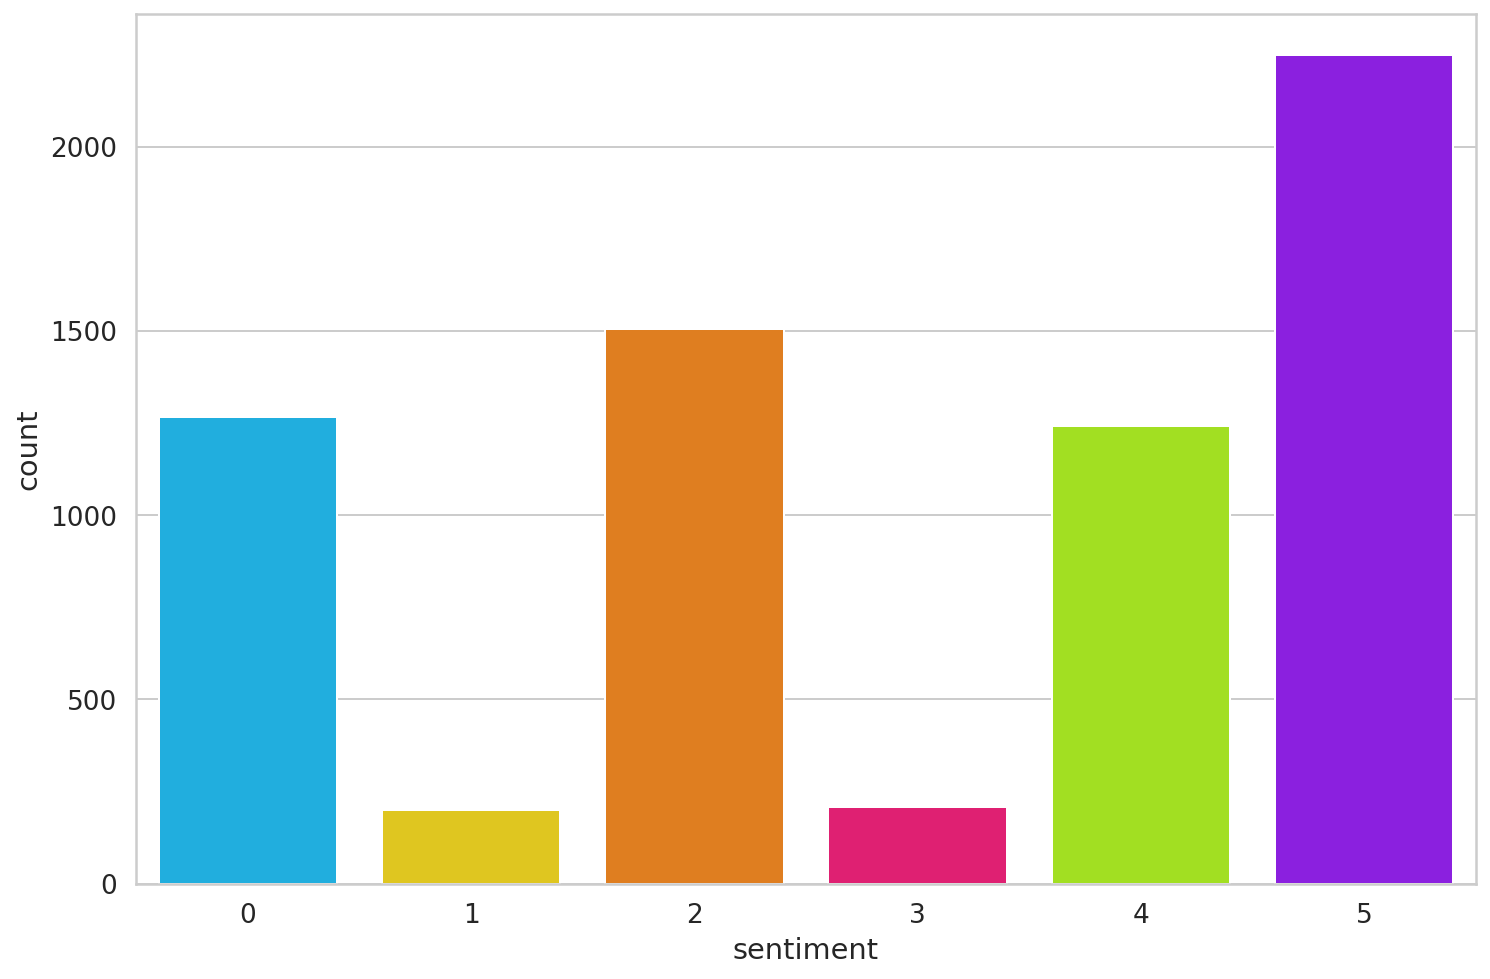

In [8]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment')

In [9]:
class_names = ['analytical','anger','confident','fear','sadness ',' tentative']


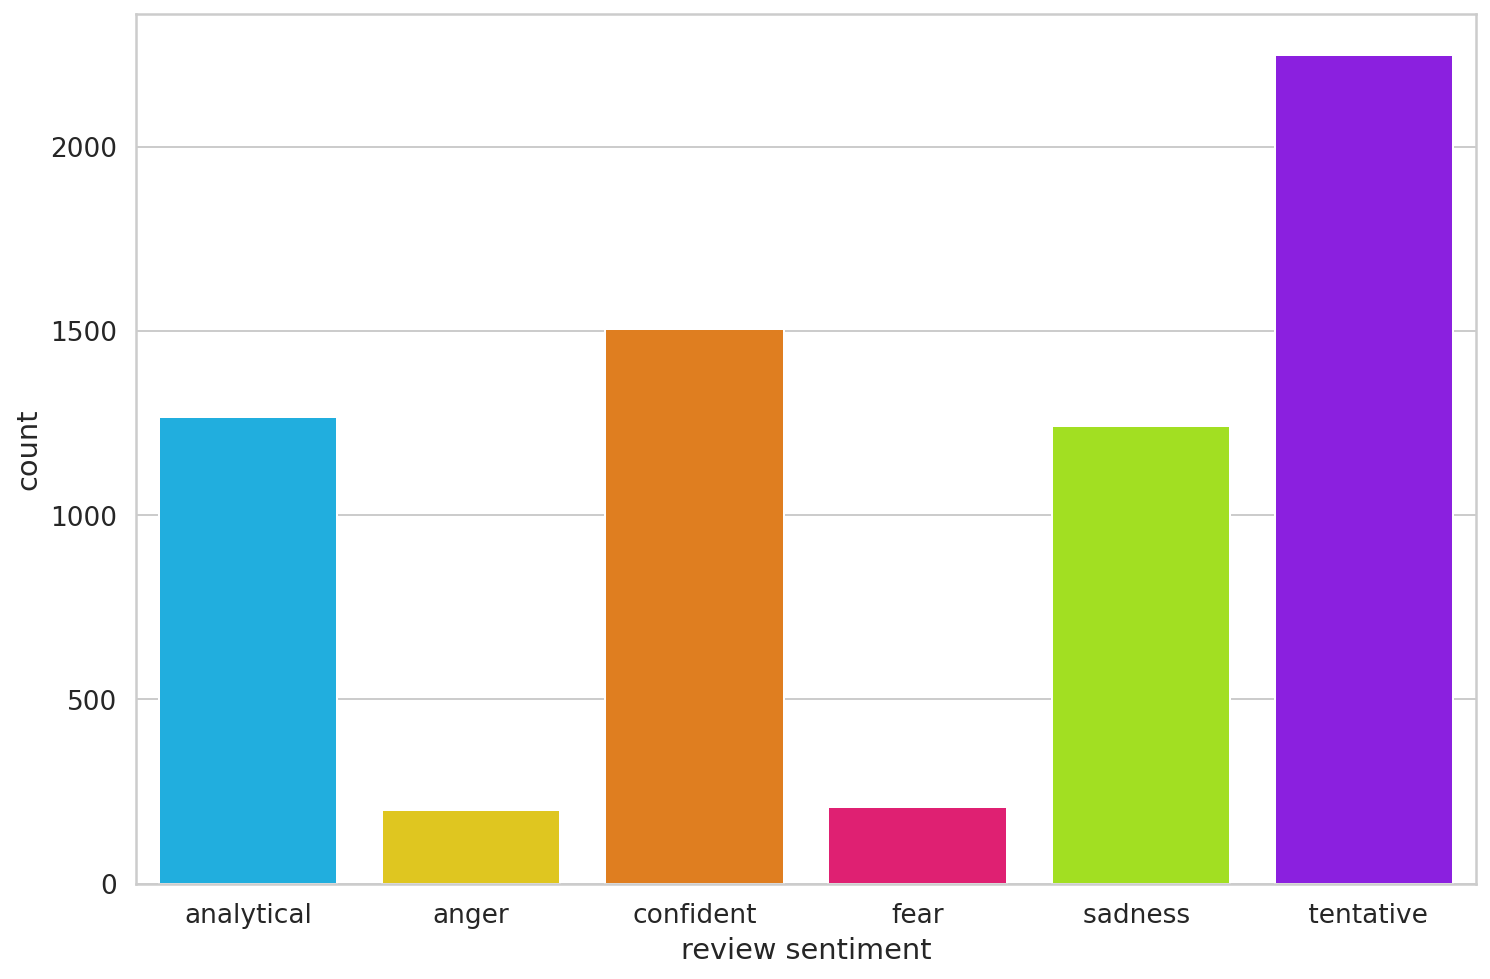

In [10]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
!pip install pytorch_transformers

     |████████████████████████████████| 176 kB 7.7 MB/s eta 0:00:01


In [ ]:
!pip install pytorch-pretrained-bert

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [18]:
sample_txt = '120,000 Americans have died from COVID-19 .At least 84,000 of these deaths could have been prevented if we had acted as quickly as Germany, Australia, South Korea and Singapore to prevent the spread of this deadly virus .This is the mind of a criminal '

In [19]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 120,000 Americans have died from COVID-19 .At least 84,000 of these deaths could have been prevented if we had acted as quickly as Germany, Australia, South Korea and Singapore to prevent the spread of this deadly virus .This is the mind of a criminal 
   Tokens: ['120', ',', '000', 'Americans', 'have', 'died', 'from', 'CO', '##VI', '##D', '-', '19', '.', 'At', 'least', '84', ',', '000', 'of', 'these', 'deaths', 'could', 'have', 'been', 'prevented', 'if', 'we', 'had', 'acted', 'as', 'quickly', 'as', 'Germany', ',', 'Australia', ',', 'South', 'Korea', 'and', 'Singapore', 'to', 'prevent', 'the', 'spread', 'of', 'this', 'deadly', 'virus', '.', 'This', 'is', 'the', 'mind', 'of', 'a', 'criminal']
Token IDs: [5356, 117, 1288, 4038, 1138, 1452, 1121, 18732, 23314, 2137, 118, 1627, 119, 1335, 1655, 5731, 117, 1288, 1104, 1292, 6209, 1180, 1138, 1151, 8369, 1191, 1195, 1125, 5376, 1112, 1976, 1112, 1860, 117, 1754, 117, 1375, 3577, 1105, 4478, 1106, 3843, 1103, 2819, 1104, 1142, 1031

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id


In [20]:
tokenizer.cls_token, tokenizer.cls_token_id


('[CLS]', 101)

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id


('[PAD]', 0)

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id


('[UNK]', 100)

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=60,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

60


tensor([  101,  5356,   117,  1288,  4038,  1138,  1452,  1121, 18732, 23314,
         2137,   118,  1627,   119,  1335,  1655,  5731,   117,  1288,  1104,
         1292,  6209,  1180,  1138,  1151,  8369,  1191,  1195,  1125,  5376,
         1112,  1976,  1112,  1860,   117,  1754,   117,  1375,  3577,  1105,
         4478,  1106,  3843,  1103,  2819,  1104,  1142, 10310,  7942,   119,
         1188,  1110,  1103,  1713,  1104,   170,  4771,   102,     0,     0])

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']


60


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 '120',
 ',',
 '000',
 'Americans',
 'have',
 'died',
 'from',
 'CO',
 '##VI',
 '##D',
 '-',
 '19',
 '.',
 'At',
 'least',
 '84',
 ',',
 '000',
 'of',
 'these',
 'deaths',
 'could',
 'have',
 'been',
 'prevented',
 'if',
 'we',
 'had',
 'acted',
 'as',
 'quickly',
 'as',
 'Germany',
 ',',
 'Australia',
 ',',
 'South',
 'Korea',
 'and',
 'Singapore',
 'to',
 'prevent',
 'the',
 'spread',
 'of',
 'this',
 'deadly',
 'virus',
 '.',
 'This',
 'is',
 'the',
 'mind',
 'of',
 'a',
 'criminal',
 '[SEP]',
 '[PAD]',
 '[PAD]']

In [27]:
token_lens = []
for txt in df.cleaned_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

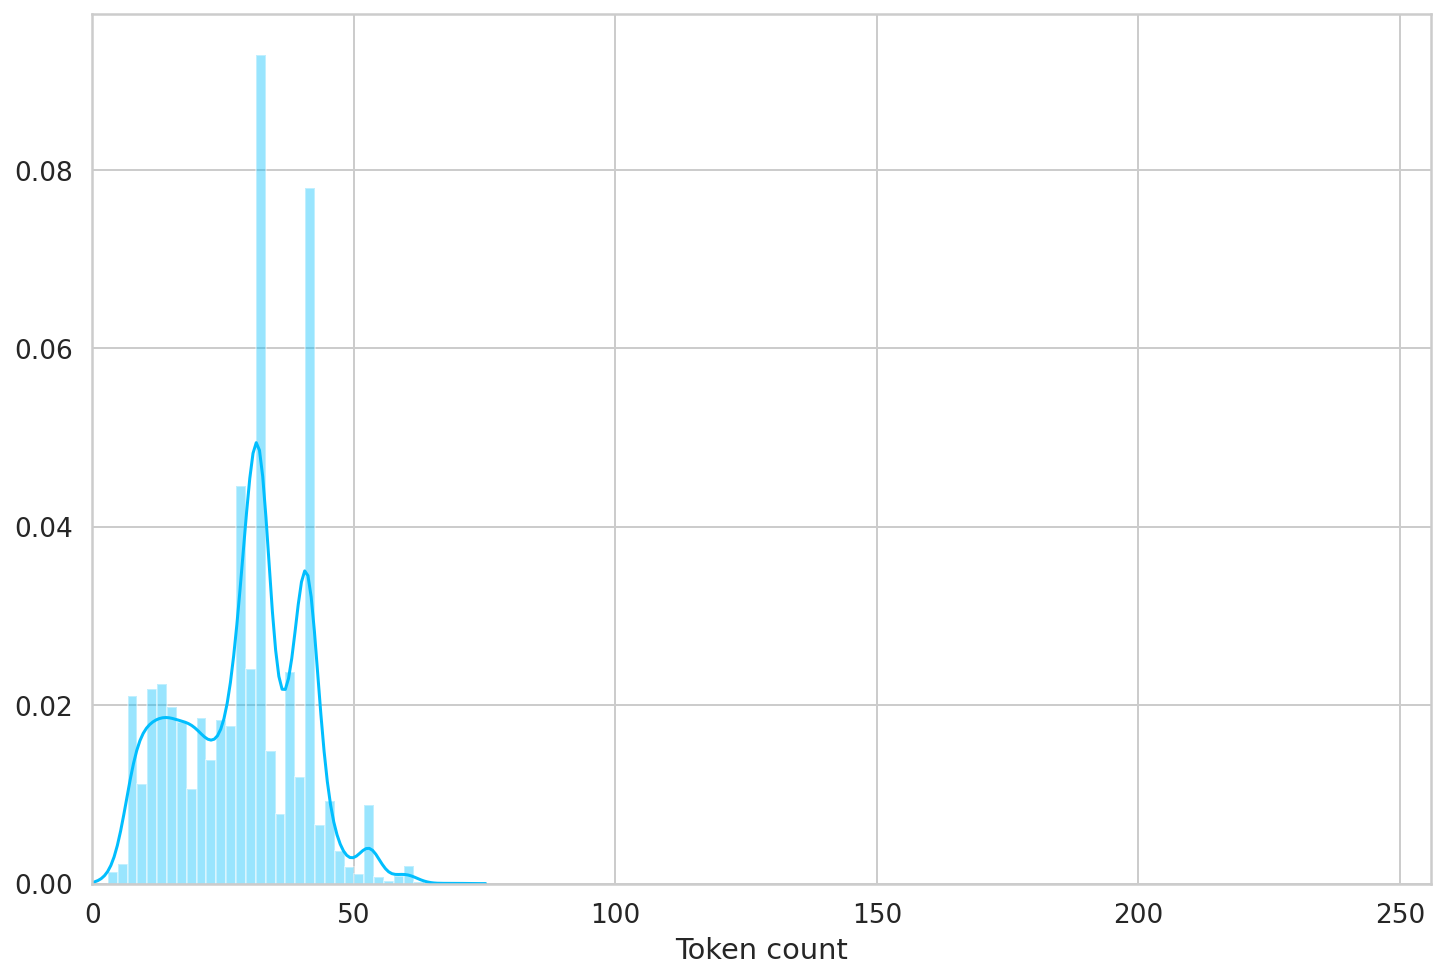

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [29]:
MAX_LEN = 160


In [30]:
class GPReviewDataset(Dataset):
  def __init__(self, cleaned_text, targets, tokenizer, max_len):
    self.cleaned_text = cleaned_text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.cleaned_text)
  def __getitem__(self, item):
    cleaned_text = str(self.cleaned_text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      cleaned_text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'cleaned_text': cleaned_text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [31]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((6003, 24), (333, 24), (334, 24))

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    cleaned_text=df.cleaned_text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [34]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['cleaned_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [38]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [39]:
last_hidden_state.shape

torch.Size([1, 60, 768])

In [40]:
bert_model.config.hidden_size

768

In [41]:
pooled_output.shape

torch.Size([1, 768])

In [42]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [43]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [45]:
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2477, 0.1251, 0.2628, 0.1449, 0.1619, 0.0576],
        [0.2840, 0.0825, 0.1921, 0.1318, 0.2198, 0.0897],
        [0.1906, 0.0976, 0.3717, 0.0875, 0.1795, 0.0731],
        [0.3594, 0.0892, 0.2320, 0.1219, 0.1412, 0.0563],
        [0.3147, 0.0999, 0.1523, 0.1025, 0.2589, 0.0718],
        [0.1999, 0.1013, 0.3110, 0.0949, 0.2157, 0.0771],
        [0.2140, 0.0610, 0.2652, 0.0825, 0.2993, 0.0780],
        [0.1816, 0.1792, 0.2658, 0.1247, 0.1832, 0.0654],
        [0.2027, 0.0934, 0.3789, 0.1091, 0.1498, 0.0662],
        [0.1307, 0.1186, 0.2747, 0.1406, 0.2968, 0.0387],
        [0.2104, 0.1013, 0.2195, 0.1198, 0.2773, 0.0717],
        [0.2453, 0.1497, 0.2455, 0.0905, 0.2318, 0.0373],
        [0.3239, 0.0537, 0.2223, 0.1531, 0.1846, 0.0624],
        [0.2521, 0.0988, 0.1735, 0.1449, 0.2140, 0.1167],
        [0.2405, 0.1105, 0.2478, 0.1723, 0.1681, 0.0608],
        [0.1899, 0.1217, 0.2128, 0.1148, 0.2773, 0.0835]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [46]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7023571767210168 accuracy 0.7499583541562552
Val   loss 0.42308092010872705 accuracy 0.8588588588588588

Epoch 2/10
----------
Train loss 0.2694959517449458 accuracy 0.9150424787606197
Val   loss 0.5224717085560163 accuracy 0.8738738738738738

Epoch 3/10
----------
Train loss 0.12217258395128042 accuracy 0.9661835748792271
Val   loss 0.5994079992884681 accuracy 0.8888888888888888

Epoch 4/10
----------
Train loss 0.05159821449148907 accuracy 0.9846743295019158
Val   loss 0.6510279774665833 accuracy 0.8978978978978979

Epoch 5/10
----------
Train loss 0.02401589903425663 accuracy 0.9935032483758122
Val   loss 0.6907594473589034 accuracy 0.9009009009009009

Epoch 6/10
----------
Train loss 0.01019515778790129 accuracy 0.9973346660003333
Val   loss 0.7144778966903687 accuracy 0.8918918918918919

Epoch 7/10
----------
Train loss 0.005693147262795816 accuracy 0.9985007496251875
Val   loss 0.7565492533502125 accuracy 0.8978978978978979

Epoch 8/10
---------

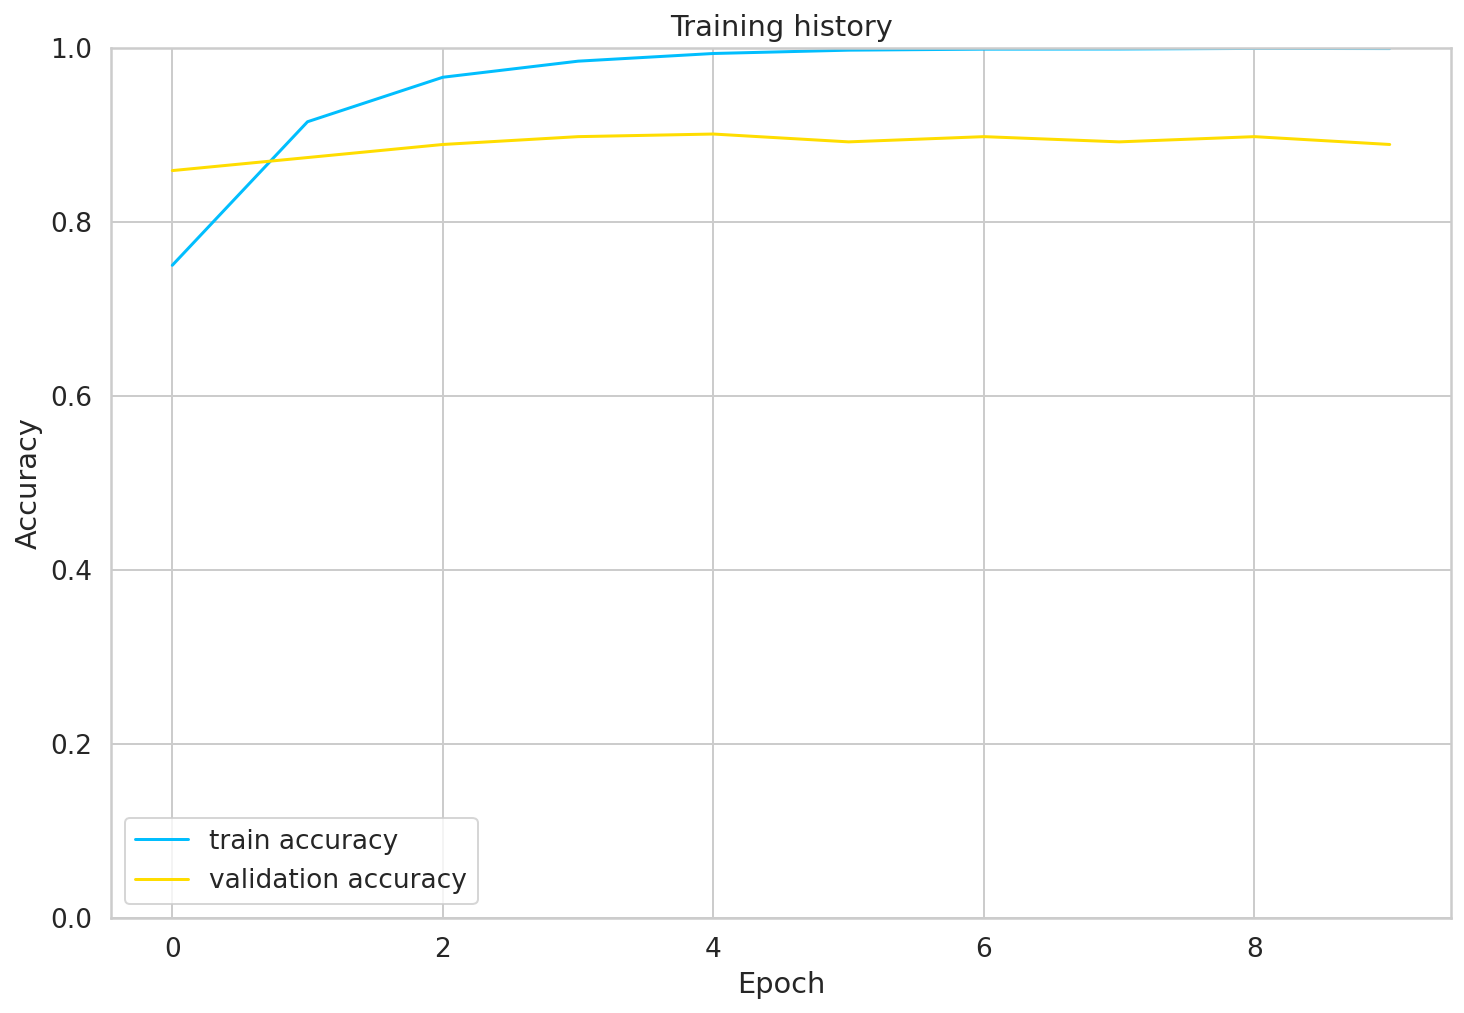

In [51]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [52]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9161676646706587

In [53]:
def get_predictions(model, data_loader):
  model = model.eval()
  cleaned_text = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["cleaned_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      cleaned_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return cleaned_text, predictions, prediction_probs, real_values

In [54]:
y_cleaned_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [55]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  analytical       0.80      0.90      0.85        52
       anger       0.80      0.57      0.67         7
   confident       0.98      0.93      0.95        86
        fear       1.00      0.64      0.78        11
    sadness        0.86      0.84      0.85        57
   tentative       0.96      0.99      0.98       121

    accuracy                           0.92       334
   macro avg       0.90      0.81      0.84       334
weighted avg       0.92      0.92      0.92       334



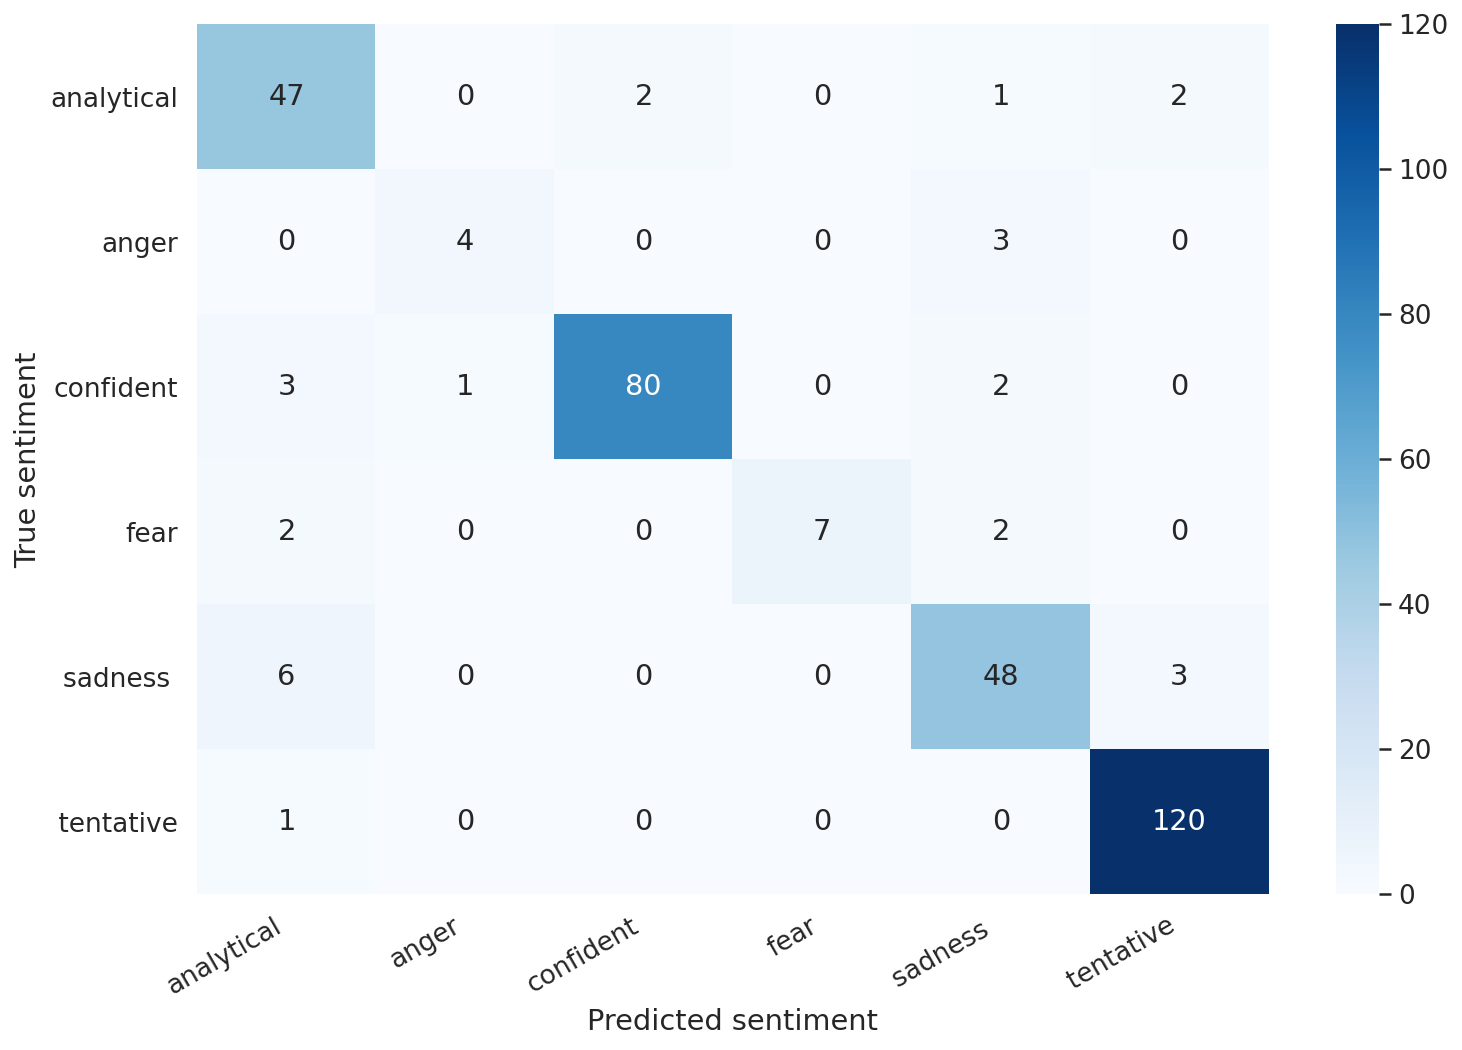

In [56]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [58]:
idx = 4
cleaned_text = y_cleaned_text[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [59]:
print("\n".join(wrap(cleaned_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

washington post sudden remove daily china virus death tracker front
page covid death decrease nationwide?  i guess doesn’t fit narrative
anymore.  🤔

True sentiment:  tentative


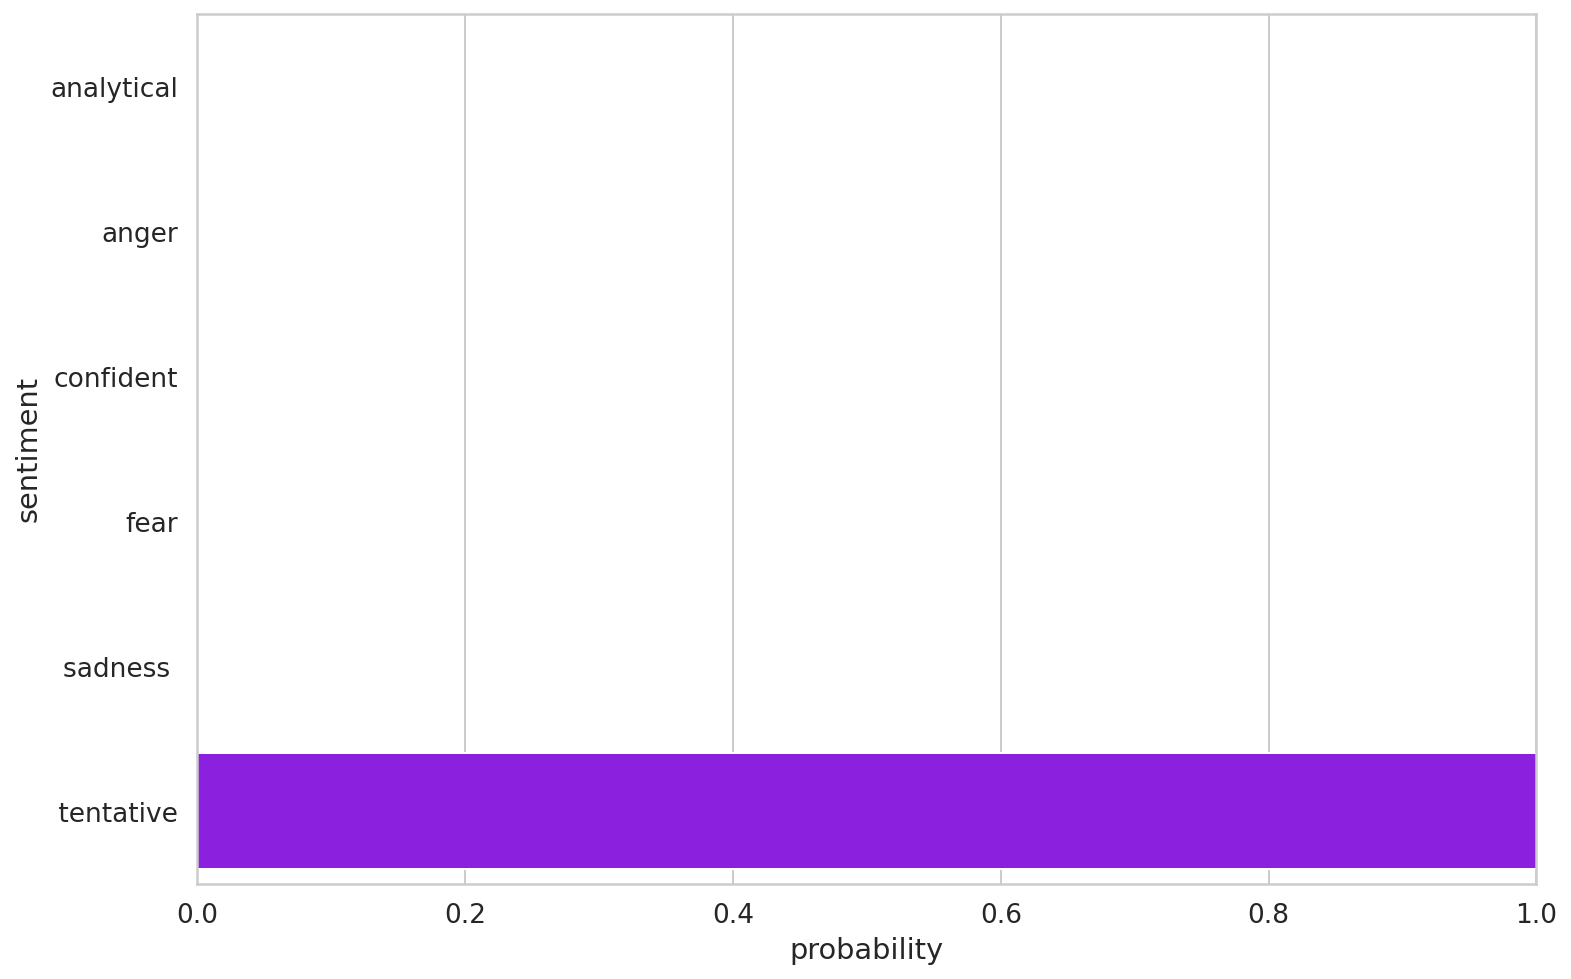

In [60]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [61]:
cleaned_text = "Many deaths have happend due to corona virus"

In [62]:
encoded_review = tokenizer.encode_plus(
  cleaned_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [63]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'cleaned text: {cleaned_text}')
print(f'Sentiment  : {class_names[prediction]}')

cleaned text: Many deaths have happend due to corona virus
Sentiment  : sadness 
